In [15]:
# Importación de las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random  # Necesario para la función random.sample en visualización de escalado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats

In [2]:
# A. Limpieza de datos

# 1. Construcción del DataFrame
# Cargamos los datos desde la URL proporcionada
url = 'https://raw.githubusercontent.com/jpospinalo/MachineLearning/main/Logistic%20Regression/german_credit_data.csv'
# En caso de problemas con la URL, puedes descargar el archivo y cargarlo localmente:
# df = pd.read_csv('german_credit_data.csv')

try:
    df = pd.read_csv(url)
    print("Datos cargados exitosamente desde la URL.")
except:
    print("Error al cargar los datos desde la URL. Por favor, descarga el archivo y cárgalo localmente.")
    # Aquí asumimos que el archivo se ha descargado localmente
    df = pd.read_csv('german_credit_data.csv')

Datos cargados exitosamente desde la URL.


In [3]:
# 2. Verificación de los tipos de datos para cada columna
print("\n--- Información del DataFrame ---")
print(df.info())

# Mostrar las primeras filas para entender la estructura de los datos
print("\n--- Primeras 5 filas del DataFrame ---")
print(df.head())


--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None

--- Primeras 5 filas del DataFrame ---
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1

In [4]:
# 3. Verificación de valores duplicados y problemas de formato
# Revisamos si hay filas duplicadas
duplicated_rows = df.duplicated().sum()
print(f"\nFilas duplicadas en el dataset: {duplicated_rows}")

# Analizamos valores únicos por columna para detectar posibles problemas de formato
print("\n--- Análisis de valores únicos por columna ---")
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {len(unique_values)} valores únicos. Ejemplos: {unique_values[:5]}")


Filas duplicadas en el dataset: 0

--- Análisis de valores únicos por columna ---
Unnamed: 0: 1000 valores únicos. Ejemplos: [0 1 2 3 4]
Age: 53 valores únicos. Ejemplos: [67 22 49 45 53]
Sex: 2 valores únicos. Ejemplos: ['male' 'female']
Job: 4 valores únicos. Ejemplos: [2 1 3 0]
Housing: 3 valores únicos. Ejemplos: ['own' 'free' 'rent']
Saving accounts: 5 valores únicos. Ejemplos: [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account: 4 valores únicos. Ejemplos: ['little' 'moderate' nan 'rich']
Credit amount: 921 valores únicos. Ejemplos: [1169 5951 2096 7882 4870]
Duration: 33 valores únicos. Ejemplos: [ 6 48 12 42 24]
Purpose: 8 valores únicos. Ejemplos: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business']
Risk: 2 valores únicos. Ejemplos: ['good' 'bad']



--- Análisis de valores faltantes ---
                  Missing Values  Percentage
Saving accounts              183        18.3
Checking account             394        39.4


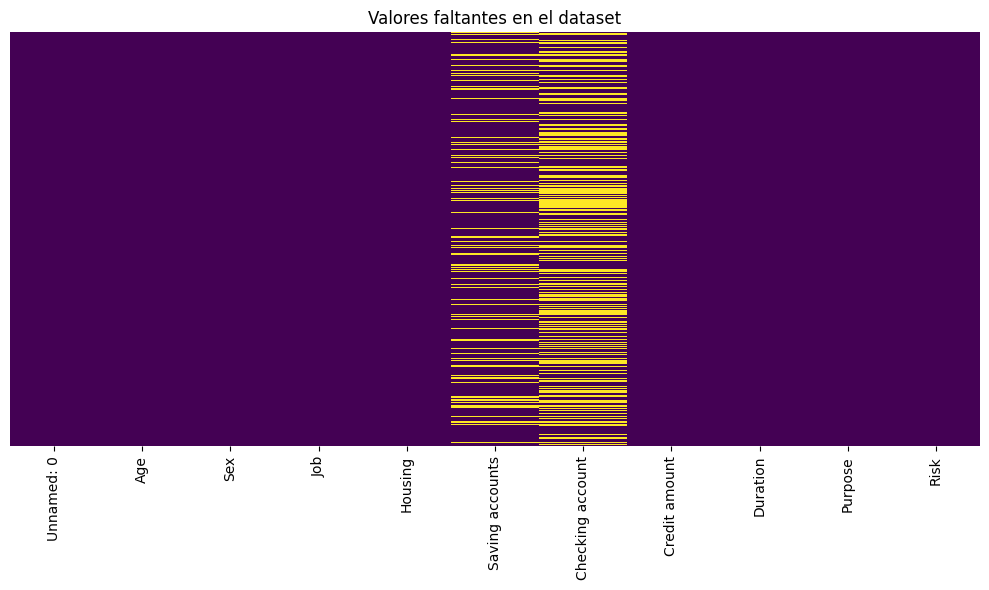

In [5]:
# 4. Verificación de valores faltantes
print("\n--- Análisis de valores faltantes ---")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 
                            'Percentage': missing_percentage.round(2)})
print(missing_info[missing_info['Missing Values'] > 0])

# Visualización de valores faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Valores faltantes en el dataset')
plt.tight_layout()
plt.savefig('missing_values_heatmap.png')


--- Análisis de valores atípicos en columnas numéricas ---
        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000
Columna Unnamed: 0: 0 valores atípicos usando Z-score (|z| > 3)
Columna Unnamed: 0: 0 valores atípicos usando IQR
Columna Age: 7 valores atípicos usando Z-score (|z| > 3)
Columna Age: 23 valores atípicos usando IQR
Columna Job: 0 valores atípicos usando Z-score (|z| > 3)
Columna Job

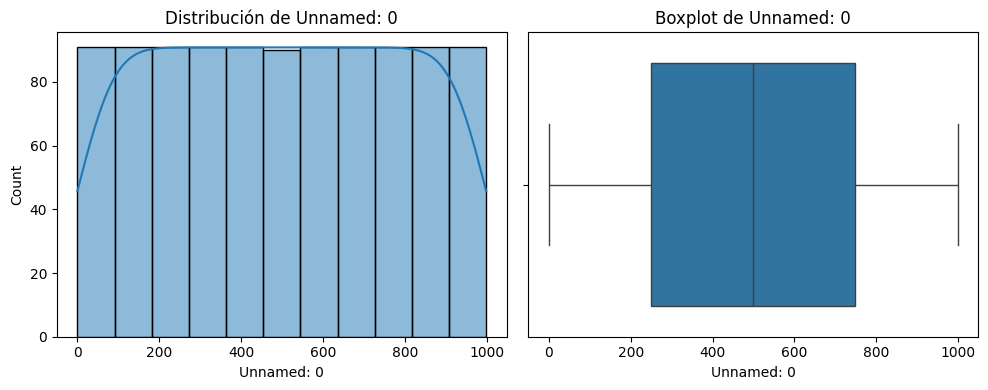

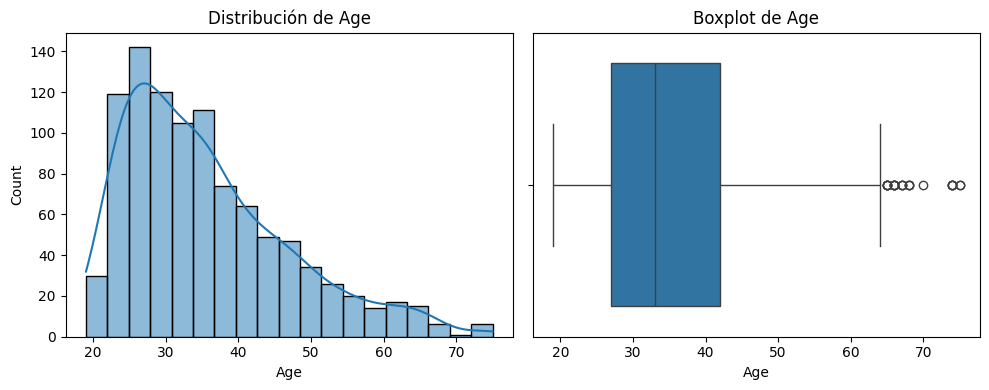

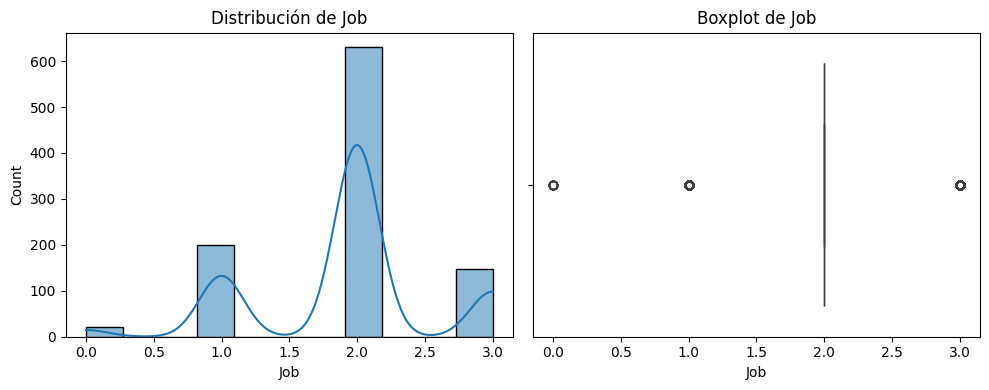

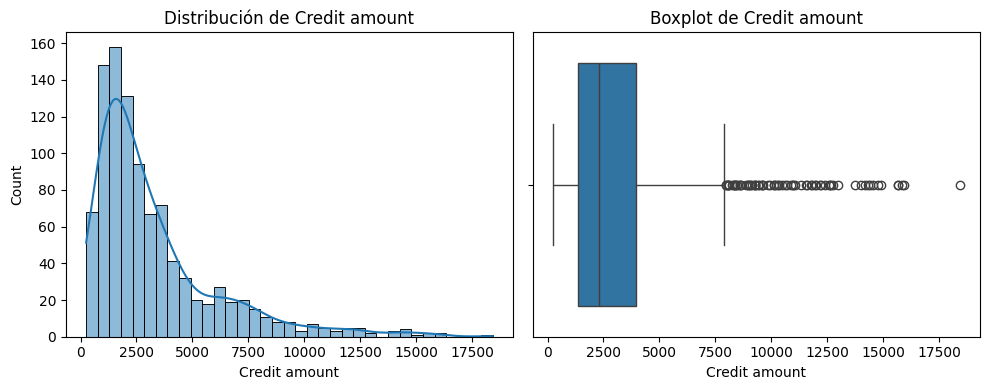

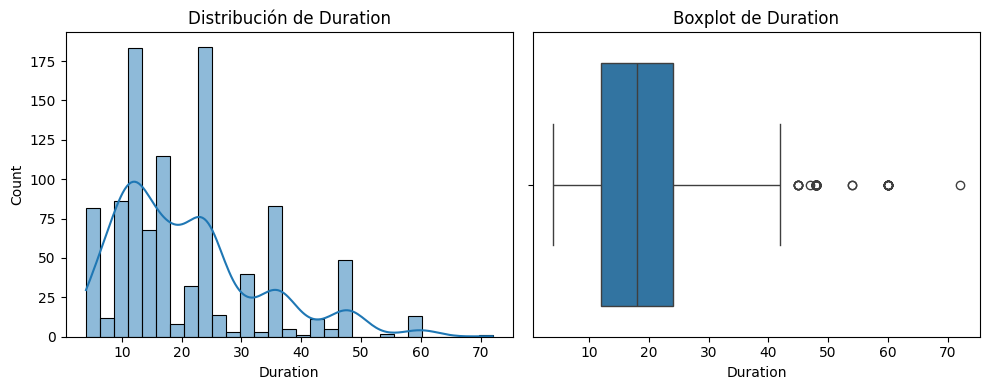

In [6]:
# B. Transformaciones

# 1. Comprobación de valores atípicos en columnas numéricas
print("\n--- Análisis de valores atípicos en columnas numéricas ---")
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Estadísticas descriptivas para columnas numéricas
print(df[numeric_columns].describe())

# Visualización de distribuciones y detección de outliers con boxplots
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    
    # Histograma para ver distribución
    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Distribución de {column}')
    
    # Boxplot para detectar outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column].dropna())
    plt.title(f'Boxplot de {column}')
    
    plt.tight_layout()
    plt.savefig(f'{column}_distribution.png')
    
    # Detección de outliers usando Z-score
    z_scores = stats.zscore(df[column].dropna())
    outliers = (abs(z_scores) > 3).sum()
    print(f"Columna {column}: {outliers} valores atípicos usando Z-score (|z| > 3)")
    
    # Detección de outliers usando IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    print(f"Columna {column}: {outliers_iqr} valores atípicos usando IQR")

In [13]:
# 2. Imputación de valores faltantes

# Creamos una función específica para analizar los cambios de imputación
def analizar_imputacion(df_original, df_imputado):
    """
    Analiza y muestra los cambios realizados durante el proceso de imputación
    
    Args:
        df_original: DataFrame original con valores faltantes
        df_imputado: DataFrame después de la imputación
        
    Returns:
        resumen_imputacion: DataFrame con el resumen de la imputación
    """
    print("\n" + "="*80)
    print(" ANÁLISIS DETALLADO DEL PROCESO DE IMPUTACIÓN DE VALORES FALTANTES ")
    print("="*80)
    
    # Identificamos columnas con valores faltantes
    columns_with_missing = df_original.columns[df_original.isnull().any()].tolist()
    
    if not columns_with_missing:
        print("No se encontraron valores faltantes en el dataset original.")
        return None
    
    print(f"\n1. Se encontraron {len(columns_with_missing)} columnas con valores faltantes:")
    for col in columns_with_missing:
        missing_count = df_original[col].isnull().sum()
        total_count = len(df_original)
        missing_percentage = (missing_count / total_count) * 100
        print(f"   - '{col}': {missing_count} valores faltantes ({missing_percentage:.2f}% del total)")
    
    # Separamos columnas numéricas y categóricas
    numeric_cols = df_original.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df_original.select_dtypes(include=['object']).columns.tolist()
    
    print("\n2. Estrategias de imputación aplicadas:")
    
    # Preparamos un DataFrame para almacenar el resumen
    resumen_imputacion = []
    
    # Analizamos cada columna con valores faltantes
    for column in columns_with_missing:
        # Identificamos las filas con valores faltantes
        missing_indices = df_original[df_original[column].isnull()].index.tolist()
        
        # Determinamos el valor de imputación utilizado
        if column in numeric_cols:
            imputation_value = df_original[column].median()
            strategy = "Mediana"
        else:
            imputation_value = df_original[column].mode()[0]
            strategy = "Moda (valor más frecuente)"
        
        # Creamos un resumen para esta columna
        column_summary = {
            'Columna': column,
            'Tipo': 'Numérica' if column in numeric_cols else 'Categórica',
            'Valores_Faltantes': len(missing_indices),
            'Porcentaje_Faltantes': round((len(missing_indices) / len(df_original) * 100), 2),
            'Estrategia': strategy,
            'Valor_Imputación': imputation_value
        }
        
        # Añadimos este resumen a nuestra lista
        resumen_imputacion.append(column_summary)
        
        # Mostramos información sobre la imputación
        print(f"\n   Columna: '{column}' ({column_summary['Tipo']})")
        print(f"   - Estrategia: {strategy}")
        print(f"   - Valor de imputación: {imputation_value}")
        
        # Creamos un DataFrame de ejemplo con los cambios
        sample_size = min(5, len(missing_indices))
        if sample_size > 0:
            sample_indices = missing_indices[:sample_size]
            sample_data = {
                'Índice': sample_indices,
                'Valor_Original': ['NaN'] * sample_size,
                'Valor_Imputado': df_imputado.loc[sample_indices, column].values
            }
            sample_df = pd.DataFrame(sample_data)
            print(f"\n   Ejemplo de {sample_size} filas imputadas:")
            print(sample_df.to_string(index=False))
    
    # Convertimos el resumen a DataFrame para facilitar su visualización y análisis
    df_resumen = pd.DataFrame(resumen_imputacion)
    
    print("\n" + "="*80)
    print(" RESUMEN GLOBAL DE LA IMPUTACIÓN ")
    print("="*80)
    print("\nTabla de resumen de imputaciones realizadas:")
    print(df_resumen.to_string(index=False))
    
    # Guardamos el resumen a un archivo CSV para referencia futura
    df_resumen.to_csv('resumen_imputacion.csv', index=False)
    print("\nSe ha guardado el resumen completo en 'resumen_imputacion.csv'")
    
    # Verificamos la efectividad de la imputación
    missing_after = df_imputado.isnull().sum().sum()
    if missing_after == 0:
        print("\nLa imputación fue exitosa: No quedan valores faltantes en el dataset.")
    else:
        print(f"\n¡ADVERTENCIA! Aún quedan {missing_after} valores faltantes después de la imputación.")
    
    return df_resumen

# Creamos una copia del dataframe para las transformaciones
df_transformed = df.copy()

# Separamos en columnas numéricas y categóricas para procesamiento
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print("\n--- Aplicando proceso de imputación ---")

# Para columnas numéricas usamos la mediana para la imputación
numeric_imputer = SimpleImputer(strategy='median')
df_transformed[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Para columnas categóricas usamos la moda (valor más frecuente)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_transformed[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Llamamos a nuestra función para analizar los cambios
resumen_imputacion = analizar_imputacion(df, df_transformed)

# Para entender mejor el impacto, creamos una visualización tabular de los cambios
# en la distribución de columnas numéricas antes vs después de la imputación
if numeric_columns:
    print("\n" + "="*80)
    print(" ESTADÍSTICAS ANTES VS DESPUÉS DE LA IMPUTACIÓN (COLUMNAS NUMÉRICAS) ")
    print("="*80)
    
    # Para cada columna numérica con valores faltantes, mostramos estadísticas comparativas
    for column in numeric_columns:
        if df[column].isnull().sum() > 0:
            print(f"\nEstadísticas para '{column}':")
            
            # Comparamos estadísticas antes vs después
            stats_before = df[column].describe()
            stats_after = df_transformed[column].describe()
            
            comparison = pd.DataFrame({
                'Antes de imputación': stats_before,
                'Después de imputación': stats_after,
                'Diferencia': stats_after - stats_before
            })
            
            print(comparison)
            
            # Valores antes de imputación vs después
            original_nonnull = df[column].dropna()
            print(f"\nMuestra antes (sin NaN): {list(original_nonnull.head(5))}")
            print(f"Muestra después: {list(df_transformed[column].head(5))}")
            
            # Impacto en distribución
            median_val = df[column].median()
            print(f"\nValor de imputación (mediana): {median_val}")
            print(f"Número de valores imputados: {df[column].isnull().sum()}")
            print(f"Porcentaje del total: {(df[column].isnull().sum() / len(df) * 100):.2f}%")




--- Aplicando proceso de imputación ---

 ANÁLISIS DETALLADO DEL PROCESO DE IMPUTACIÓN DE VALORES FALTANTES 

1. Se encontraron 2 columnas con valores faltantes:
   - 'Saving accounts': 183 valores faltantes (18.30% del total)
   - 'Checking account': 394 valores faltantes (39.40% del total)

2. Estrategias de imputación aplicadas:

   Columna: 'Saving accounts' (Categórica)
   - Estrategia: Moda (valor más frecuente)
   - Valor de imputación: little

   Ejemplo de 5 filas imputadas:
 Índice Valor_Original Valor_Imputado
      0            NaN         little
      5            NaN         little
     16            NaN         little
     17            NaN         little
     24            NaN         little

   Columna: 'Checking account' (Categórica)
   - Estrategia: Moda (valor más frecuente)
   - Valor de imputación: little

   Ejemplo de 5 filas imputadas:
 Índice Valor_Original Valor_Imputado
      2            NaN         little
      5            NaN         little
      6     


Se ha guardado el resumen completo en 'resumen_imputacion.csv'

La imputación fue exitosa: No quedan valores faltantes en el dataset.

 ESTADÍSTICAS ANTES VS DESPUÉS DE LA IMPUTACIÓN (COLUMNAS NUMÉRICAS) 


In [17]:
# 3. Escalado de datos numéricos

# Creamos una función para visualizar el proceso de escalado
def visualizar_escalado(df_original, df_escalado, metodo="StandardScaler"):
    """
    Visualiza el efecto del escalado en las columnas numéricas
    
    Args:
        df_original: DataFrame con datos originales
        df_escalado: DataFrame con datos escalados
        metodo: Nombre del método de escalado utilizado
    """
    print("\n" + "="*80)
    print(f" ANÁLISIS DETALLADO DEL PROCESO DE ESCALADO DE DATOS NUMÉRICOS ({metodo}) ")
    print("="*80)
    
    # Identificamos columnas numéricas
    numeric_columns = df_original.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    if not numeric_columns:
        print("No se encontraron columnas numéricas en el dataset original.")
        return
    
    print(f"\n1. Se encontraron {len(numeric_columns)} columnas numéricas para escalar:")
    for col in numeric_columns:
        print(f"   - '{col}'")
    
    print(f"\n2. Método de escalado utilizado: {metodo}")
    if metodo == "StandardScaler":
        print("   - Este método resta la media y divide por la desviación estándar.")
        print("   - Los datos escalados tendrán media=0 y desviación estándar=1.")
        print("   - Fórmula: z = (x - μ) / σ")
    elif metodo == "MinMaxScaler":
        print("   - Este método escala los datos al rango [0,1].")
        print("   - Fórmula: z = (x - min) / (max - min)")
    
    print("\n3. Comparación de estadísticas antes vs después del escalado:")
    
    # Para cada columna numérica, mostramos estadísticas y ejemplos
    for column in numeric_columns:
        print(f"\n   Columna: '{column}'")
        
        # Estadísticas originales
        stats_original = df_original[column].describe()
        
        # Estadísticas después del escalado
        stats_escalado = df_escalado[column].describe()
        
        # Creamos un DataFrame comparativo
        comparacion = pd.DataFrame({
            'Original': stats_original,
            'Escalado': stats_escalado
        })
        
        print(comparacion)
        
        # Mostrar algunos ejemplos concretos
        print("\n   Ejemplos de valores antes y después del escalado:")
        
        # Tomamos 5 ejemplos (incluyendo mínimo, máximo y algunos intermedios)
        indices = []
        # Añadimos el índice del valor mínimo
        indices.append(df_original[column].idxmin())
        # Añadimos el índice del valor máximo
        indices.append(df_original[column].idxmax())
        # Añadimos algunos valores intermedios
        cuartiles = [0.25, 0.5, 0.75]
        for q in cuartiles:
            valor_q = df_original[column].quantile(q)
            # Encontramos el índice del valor más cercano al cuartil
            idx = (df_original[column] - valor_q).abs().idxmin()
            indices.append(idx)
        
        # Eliminamos posibles duplicados
        indices = list(set(indices))
        
        # Creamos un DataFrame con los ejemplos
        ejemplos = pd.DataFrame({
            'Índice': indices,
            'Valor Original': df_original.loc[indices, column].values,
            'Valor Escalado': df_escalado.loc[indices, column].values
        })
        
        # Ordenamos por valor original
        ejemplos = ejemplos.sort_values('Valor Original').reset_index(drop=True)
        
        print(ejemplos)
        
        # Explicación de cómo se calcularon algunos valores (para el StandardScaler)
        if metodo == "StandardScaler":
            media = df_original[column].mean()
            desv_std = df_original[column].std()
            
            print(f"\n   Cálculo detallado para StandardScaler:")
            print(f"   - Media de '{column}': {media:.4f}")
            print(f"   - Desviación estándar de '{column}': {desv_std:.4f}")
            print(f"   - Fórmula aplicada: z = (x - {media:.4f}) / {desv_std:.4f}")
            
            # Mostrar el cálculo paso a paso para el primer ejemplo
            x = ejemplos.iloc[0]['Valor Original']
            z = (x - media) / desv_std
            print(f"\n   Ejemplo de cálculo para valor original = {x}:")
            print(f"   z = ({x} - {media:.4f}) / {desv_std:.4f} = {z:.4f}")
            print(f"   Valor escalado resultante: {ejemplos.iloc[0]['Valor Escalado']:.4f}")
        
        elif metodo == "MinMaxScaler":
            minimo = df_original[column].min()
            maximo = df_original[column].max()
            
            print(f"\n   Cálculo detallado para MinMaxScaler:")
            print(f"   - Valor mínimo de '{column}': {minimo}")
            print(f"   - Valor máximo de '{column}': {maximo}")
            print(f"   - Fórmula aplicada: z = (x - {minimo}) / ({maximo} - {minimo})")
            
            # Mostrar el cálculo paso a paso para el primer ejemplo
            x = ejemplos.iloc[0]['Valor Original']
            z = (x - minimo) / (maximo - minimo)
            print(f"\n   Ejemplo de cálculo para valor original = {x}:")
            print(f"   z = ({x} - {minimo}) / ({maximo} - {minimo}) = {z:.4f}")
            print(f"   Valor escalado resultante: {ejemplos.iloc[0]['Valor Escalado']:.4f}")
    
    # Guardamos un archivo CSV con ejemplos para todas las columnas
    print("\n4. Guardando ejemplos de escalado para todas las columnas...")
    
    # Preparamos un DataFrame para guardar muchos ejemplos
    filas_muestra = min(50, len(df_original))  # Limitamos a 50 filas para no hacer el archivo muy grande
    indices_muestra = random.sample(list(df_original.index), filas_muestra)
    
    ejemplos_todas_columnas = pd.DataFrame(index=indices_muestra)
    
    for column in numeric_columns:
        ejemplos_todas_columnas[f"{column}_original"] = df_original.loc[indices_muestra, column].values
        ejemplos_todas_columnas[f"{column}_escalado"] = df_escalado.loc[indices_muestra, column].values
    
    # Guardamos a CSV
    ejemplos_todas_columnas.to_csv(f'ejemplos_escalado_{metodo}.csv')
    print(f"   Archivo guardado como 'ejemplos_escalado_{metodo}.csv'")

# Creamos una copia de los datos antes del escalado
df_antes_escalado = df_transformed.copy()

# Aplicamos StandardScaler a las columnas numéricas
print("\n--- Aplicando escalado de datos numéricos ---")
scaler = StandardScaler()
df_transformed[numeric_columns] = scaler.fit_transform(df_transformed[numeric_columns])

# Llamamos a nuestra función para visualizar los cambios
visualizar_escalado(df_antes_escalado, df_transformed, metodo="StandardScaler")

# Información adicional para entender mejor
print("\n--- Información teórica sobre el escalado de datos ---")
print("""
El escalado de datos es un paso crucial en el preprocesamiento para muchos algoritmos de
machine learning. Existen principalmente dos tipos de escalado:

1. StandardScaler (Escalado Estándar):
   - Transforma los datos para que tengan media 0 y desviación estándar 1.
   - Es útil cuando los datos siguen una distribución normal (o aproximadamente normal).
   - Es sensible a valores atípicos (outliers).
   - Es recomendado para algoritmos como SVM, regresión logística y redes neuronales.

2. MinMaxScaler (Escalado Min-Max):
   - Escala los datos al rango [0,1] o cualquier otro rango especificado.
   - Preserva la forma de la distribución original, solo cambia la escala.
   - Es menos sensible a outliers que StandardScaler.
   - Es recomendado para algoritmos que requieren datos positivos o en un rango específico.

En este caso, hemos utilizado StandardScaler porque:
- Normaliza los datos alrededor de la media, lo que es beneficioso para muchos algoritmos.
- Hace que todas las características tengan la misma escala, evitando que algunas dominen sobre otras.
- Es especialmente útil para métodos basados en distancias o que asumen normalidad.
""")





--- Aplicando escalado de datos numéricos ---

 ANÁLISIS DETALLADO DEL PROCESO DE ESCALADO DE DATOS NUMÉRICOS (StandardScaler) 

1. Se encontraron 5 columnas numéricas para escalar:
   - 'Unnamed: 0'
   - 'Age'
   - 'Job'
   - 'Credit amount'
   - 'Duration'

2. Método de escalado utilizado: StandardScaler
   - Este método resta la media y divide por la desviación estándar.
   - Los datos escalados tendrán media=0 y desviación estándar=1.
   - Fórmula: z = (x - μ) / σ

3. Comparación de estadísticas antes vs después del escalado:

   Columna: 'Unnamed: 0'
         Original    Escalado
count  1000.00000  1000.00000
mean      0.00000     0.00000
std       1.00050     1.00050
min      -1.73032    -1.73032
25%      -0.86516    -0.86516
50%       0.00000     0.00000
75%       0.86516     0.86516
max       1.73032     1.73032

   Ejemplos de valores antes y después del escalado:
   Índice  Valor Original  Valor Escalado
0       0       -1.730320       -1.730320
1     250       -0.864294    

In [23]:
# 4. Codificación de datos categóricos

# 4. Guardamos un archivo CSV con ejemplos para todas las columnas
print("\n4. Guardando ejemplos de codificación para todas las columnas...")
    
    # Preparamos un DataFrame para guardar ejemplos
indices_muestra = []
    
    # Para cada columna categórica, incluimos ejemplos de cada valor único
for column in categorical_columns:
        if column == 'Risk':  # Excluimos la variable objetivo
            continue
        for valor in df_original[column].dropna().unique():
            # Encontramos una fila con este valor
            filas = df_original[df_original[column] == valor].index
            if len(filas) > 0:
                indices_muestra.append(filas[0])
    
    # Eliminamos duplicados y limitamos a 50 filas
indices_muestra = list(set(indices_muestra))
if len(indices_muestra) > 50:
        indices_muestra = random.sample(indices_muestra, 50)
    
    # Creamos el DataFrame de ejemplos
ejemplos_todas_columnas = pd.DataFrame(index=indices_muestra)
    
    # Añadimos las columnas originales
for column in categorical_columns:
        if column == 'Risk':  # Excluimos la variable objetivo
            continue
        ejemplos_todas_columnas[f"{column}_original"] = df_original.loc[indices_muestra, column].values
    
    # Añadimos las columnas codificadas
for column in columnas_ordinales:
        if column in df_original.columns:
            ejemplos_todas_columnas[f"{column}_codificado"] = df_codificado.loc[indices_muestra, column].values
    
    # Para columnas one-hot, añadimos todas las columnas generadas
for column in columnas_nominales:
        if column in df_original.columns:
            # Identificamos las columnas generadas
            prefijo = f"{column}_"
            columnas_generadas = [col for col in df_codificado.columns if col.startswith(prefijo)]
            
            # Si no encontramos por prefijo, intentamos el método alternativo
            if not columnas_generadas:
                valores_unicos = df_original[column].dropna().unique()
                posibles_columnas = []
                for valor in valores_unicos:
                    valor_formateado = str(valor).lower().replace(' ', '_')
                    cols = [col for col in df_codificado.columns if valor_formateado in col.lower()]
                    posibles_columnas.extend(cols)
                columnas_generadas = list(set(posibles_columnas))
            
            # Añadimos cada columna generada
            for col in columnas_generadas:
                ejemplos_todas_columnas[col] = df_codificado.loc[indices_muestra, col].values
    
    # Guardamos a CSV
ejemplos_todas_columnas.to_csv('ejemplos_codificacion_categoricas.csv')
print("   Archivo guardado como 'ejemplos_codificacion_categoricas.csv'")

# Creamos una copia de los datos antes de la codificación categórica
df_antes_codificacion = df_transformed.copy()

print("\n--- Aplicando codificación de datos categóricos ---")

# Para variables categóricas ordinales (como 'Saving accounts' y 'Checking account')
# Definimos el orden de las categorías para estas variables
saving_order = ['little', 'moderate', 'quite rich', 'rich']  # Ajustar según los valores reales
checking_order = ['little', 'moderate', 'rich']  # Ajustar según los valores reales

columnas_ordinales = ['Saving accounts', 'Checking account']
columnas_nominales = [col for col in categorical_columns 
                     if col not in columnas_ordinales and col != 'Risk']

# Aplicamos OrdinalEncoder para columnas ordinales
print("\n1. Aplicando OrdinalEncoder para columnas ordinales:")
for column in columnas_ordinales:
    if column in df_transformed.columns:
        print(f"   - Codificando '{column}'")
        if column == 'Saving accounts':
            ordinal_encoder = OrdinalEncoder(categories=[saving_order])
        elif column == 'Checking account':
            ordinal_encoder = OrdinalEncoder(categories=[checking_order])
        
        # Aplicamos la codificación
        df_transformed[[column]] = ordinal_encoder.fit_transform(
            df_transformed[[column]])

# Para variables categóricas nominales (como 'Sex', 'Housing', 'Purpose')
# Usamos OneHotEncoder
print("\n2. Aplicando OneHotEncoder para columnas nominales:")
for column in columnas_nominales:
    print(f"   - Codificando '{column}'")

# Aplicamos OneHotEncoder para columnas nominales
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = onehot_encoder.fit_transform(df_transformed[columnas_nominales])
# Obtenemos los nombres de las nuevas columnas
feature_names = onehot_encoder.get_feature_names_out(columnas_nominales)
# Creamos un DataFrame con las nuevas columnas
encoded_df = pd.DataFrame(
    encoded_features, 
    columns=feature_names,
    index=df_transformed.index
)

# Concatenamos el dataframe transformado con las nuevas columnas codificadas
df_transformed = pd.concat([df_transformed.drop(columnas_nominales, axis=1), encoded_df], axis=1)

# Convertimos la variable objetivo 'Risk' a numérica (0 = 'good', 1 = 'bad')
print("\n3. Codificando la variable objetivo 'Risk':")
if 'Risk' in df_transformed.columns:
    df_transformed['Risk'] = df_transformed['Risk'].map({'good': 0, 'bad': 1})
    print(f"   - 'Risk' codificada: 'good' -> 0, 'bad' -> 1")

# Definimos la función para visualizar la codificación, en caso de que no esté definida
def visualizar_codificacion(df_original, df_transformed, columnas_ordinales, columnas_nominales):
    print("Visualización de codificación:")
    print("\nDatos originales (primeros 5 registros):")
    print(df_original.head())
    print("\nDatos transformados (primeros 5 registros):")
    print(df_transformed.head())

# Llamamos a nuestra función para visualizar los cambios
visualizar_codificacion(df_antes_codificacion, df_transformed, 
                        columnas_ordinales=columnas_ordinales, 
                        columnas_nominales=columnas_nominales)



4. Guardando ejemplos de codificación para todas las columnas...


NameError: name 'df_original' is not defined

In [10]:
# C. Pipelines de preprocesamiento

# 1. Pipeline para transformación de valores numéricos
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline para transformación de valores categóricos ordinales
# Ajustamos según las columnas reales del dataset
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# 3. Pipeline para transformación de valores categóricos nominales
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, drop='first'))
])

# 4. Pipeline final con ColumnTransformer
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('ordinal', ordinal_pipeline, ['Saving accounts', 'Checking account']),
    ('nominal', nominal_pipeline, nominal_columns)
], remainder='passthrough')

# Aplicamos el pipeline completo
X = df.drop('Risk', axis=1)
y = df['Risk']
X_transformed = preprocessor.fit_transform(X)

# Convertimos a DataFrame para mejor visualización
column_names = (
    numeric_columns + 
    ['Saving_accounts', 'Checking_account'] + 
    preprocessor.named_transformers_['nominal'].named_steps['encoder'].get_feature_names_out(nominal_columns).tolist()
)
X_transformed_df = pd.DataFrame(X_transformed, columns=column_names)

# Imprimimos las primeras 10 líneas de los datos transformados
print("\n--- Primeras 10 líneas de los datos transformados ---")
print(X_transformed_df.head(10))


--- Primeras 10 líneas de los datos transformados ---
   Unnamed: 0       Age       Job  Credit amount  Duration  Saving_accounts  \
0   -1.730320  2.766456  0.146949      -0.745131 -1.236478              0.0   
1   -1.726856 -1.191404  0.146949       0.949817  2.248194              0.0   
2   -1.723391  1.183312 -1.383771      -0.416562 -0.738668              0.0   
3   -1.719927  0.831502  0.146949       1.634247  1.750384              0.0   
4   -1.716463  1.535122  0.146949       0.566664  0.256953              0.0   
5   -1.712999 -0.048022 -1.383771       2.050009  1.252574              0.0   
6   -1.709535  1.535122  0.146949      -0.154629  0.256953              2.0   
7   -1.706071 -0.048022  1.677670       1.303197  1.252574              0.0   
8   -1.702607  2.238742 -1.383771      -0.075233 -0.738668              3.0   
9   -1.699143 -0.663689  1.677670       0.695681  0.754763              0.0   

   Checking_account  Sex_male  Housing_own  Housing_rent  Purpose_car  \
0 